In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, UpSampling1D, Flatten, MaxPooling1D, BatchNormalization, average,Convolution2D,MaxPooling2D,UpSampling2D,Conv1D,LeakyReLU,add
from tensorflow.keras.models import Model
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler
import scipy.io
import numpy as np
from tensorflow.keras import backend as K
from Units import *
import tensorflow  as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
### load well-trained model
model = load_model('best_model_3dfield.h5',custom_objects={'huber_loss_mean':huber_loss_mean})
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1728)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           110656      ['input_1[0][0]']                
                                                                

In [3]:
# Segmente the noisy data into a large number of small-scale patches  
# Load 3D noisy data
data = scipy.io.loadmat(r'.\Data\Field3D\3dfield-n.mat')
dataNoisy = data['dn']
print('The shape of 3D field data:',dataNoisy.shape)

#plot3d(dataNoisy,figsize=(16,10),cmap=cseis(),barlabel='Amplitude',showf=False,close=False)

w1 = 12
w2 = 12
w3 = 12
z1 = 4
z2 = 4
z3 = 4

dataInput = patch3d(dataNoisy,w1,w2,w3,z1,z2,z3)
#dataInputP = np.transpose(dataInputP)
#dataPatches = np.reshape(dataInput,(dataInput.shape[0],w1*w2*w3))
dataPatches = np.array(dataInput)
print(dataPatches.shape)

The shape of 3D field data: (512, 128, 32)
(22680, 1728)


In [4]:
input_img = Input(shape=(w1*w2*w3,))

# See the model.summary()
#lambda_2 denotes the outpu of the first encoder,
#lambda_4 denotes the outpu of the second encoder
#lambda_6 denotes the outpu of the second encoder

### load the first encoder
layer_model1 = Model(inputs=model.input,outputs=model.get_layer('lambda_1').output) 
model_in1 = layer_model1(input_img)
layer_model1.summary()

de1 = Dense(w1*w2*w3, activation='linear')(model_in1)

model1 = Model(inputs=input_img, outputs=de1)
model1.summary()
model1.compile(optimizer='adam', loss=huber_loss_mean)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1728)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           110656      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           110656      ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64)           0           ['dense[0][0]']                  
                                                                                              

In [5]:
def lr_schedule(epoch):
    initial_lr = 1e-3

    if epoch <= 20:
        lr = initial_lr
    elif epoch <= 40:
        lr = initial_lr / 2
    elif epoch <= 60:
        lr = 3e-4
    elif epoch <= 80:
        lr = initial_lr / 10
    else:
        lr = initial_lr / 20
   # print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.3),
                                   cooldown=0,

                                   patience=5,
                                   min_lr=0.5e-5,
                                   monitor='val_loss')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model_3dfield_our_layer.h5', monitor='val_loss', mode='min', save_best_only=True)

batch = 128

### retrain the model a first time
history1 = model1.fit(dataPatches, dataPatches, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Train on 18144 samples, validate on 4536 samples
Epoch 1/100


C:\Users\liuya444\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


18144/18144 - 1s - loss: 0.5822 - val_loss: 0.3134 - lr: 0.0010 - 906ms/epoch - 50us/sample
Epoch 2/100
18144/18144 - 1s - loss: 0.4474 - val_loss: 0.2865 - lr: 0.0010 - 592ms/epoch - 33us/sample
Epoch 3/100
18144/18144 - 1s - loss: 0.4151 - val_loss: 0.2690 - lr: 0.0010 - 602ms/epoch - 33us/sample
Epoch 4/100
18144/18144 - 1s - loss: 0.4054 - val_loss: 0.2639 - lr: 0.0010 - 620ms/epoch - 34us/sample
Epoch 5/100
18144/18144 - 1s - loss: 0.3921 - val_loss: 0.2624 - lr: 0.0010 - 626ms/epoch - 35us/sample
Epoch 6/100
18144/18144 - 1s - loss: 0.3902 - val_loss: 0.2601 - lr: 0.0010 - 621ms/epoch - 34us/sample
Epoch 7/100
18144/18144 - 1s - loss: 0.3902 - val_loss: 0.2590 - lr: 0.0010 - 743ms/epoch - 41us/sample
Epoch 8/100
18144/18144 - 1s - loss: 0.3821 - val_loss: 0.2610 - lr: 0.0010 - 818ms/epoch - 45us/sample
Epoch 9/100
18144/18144 - 1s - loss: 0.3889 - val_loss: 0.2574 - lr: 0.0010 - 768ms/epoch - 42us/sample
Epoch 10/100
18144/18144 - 1s - loss: 0.3795 - val_loss: 0.2575 - lr: 0.0010

In [6]:
out1 = model1.predict(dataPatches)
#ind1=np.random.RandomState(seed=42).permutation(len(out1))
#out1 = out1[ind1]
print("out1.shape is:",out1.shape)

scipy.io.savemat("./Data/Field3D/First_encoder.mat", mdict={'out1': out1})

C:\Users\liuya444\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


out1.shape is: (22680, 1728)


In [7]:
### load the second encoder
layer_model2 = Model(inputs=model.input,outputs=model.get_layer('lambda_3').output) 
model_in2 = layer_model2(input_img)
layer_model2.summary()

de2 = Dense(w1*w2*w3, activation='linear')(model_in2)

model2 = Model(inputs=input_img, outputs=de2)
model2.summary()
model2.compile(optimizer='adam', loss=huber_loss_mean)

### retrain the model a second time

history2 = model2.fit(dataPatches, dataPatches, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1728)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           110656      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           110656      ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64)           0           ['dense[0][0]']                  
                                                                                            

In [8]:
out2 = model2.predict(dataPatches) 
#ind2=np.random.RandomState(seed=42).permutation(len(out2))
#out2 = out2[ind2]
print("out2.shape is:",out2.shape)
scipy.io.savemat("./Data/Field3D/Second_encoder.mat", mdict={'out2': out2})

out2.shape is: (22680, 1728)


In [9]:
### load the third encoder
layer_model3 = Model(inputs=model.input,outputs=model.get_layer('lambda_5').output) 
model_in3 = layer_model3(input_img)
layer_model3.summary()

de3 = Dense(w1*w2*w3, activation='linear')(model_in3)

model3 = Model(inputs=input_img, outputs=de3)
model3.summary()
model3.compile(optimizer='adam', loss=huber_loss_mean)

history3 = model3.fit(dataPatches, dataPatches, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1728)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           110656      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           110656      ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64)           0           ['dense[0][0]']                  
                                                                                            

In [10]:
out3 = model3.predict(dataPatches) 
#ind3=np.random.RandomState(seed=42).permutation(len(out3))
#out3 = out3[ind3]
print("out3.shape is:",out3.shape)
scipy.io.savemat("./Data/Field3D/Third_encoder.mat", mdict={'out3': out3})

out3.shape is: (22680, 1728)


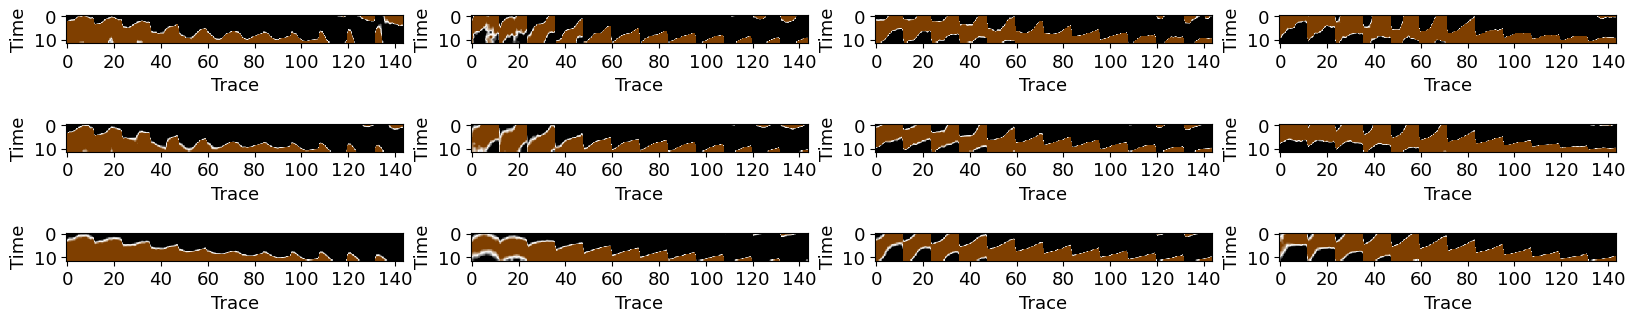

In [11]:
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax1 = plt.subplot(3, n, i + 1)
    plt.imshow(out1[i].reshape(12, 12*12),cmap=cseis(),clim=(-0.1,0.1));
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)

    ax2 = plt.subplot(3, n, i + 1 +n)
    plt.imshow(out2[i].reshape(12, 12*12),cmap=cseis(),clim=(-0.1,0.1));
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)
    
    ax3 = plt.subplot(3, n, i + 1 +2*n)
    plt.imshow(out3[i].reshape(12, 12*12),cmap=cseis(),clim=(-0.1,0.1));
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)
#plt.savefig('./out.png',dpi=1000)
plt.show()

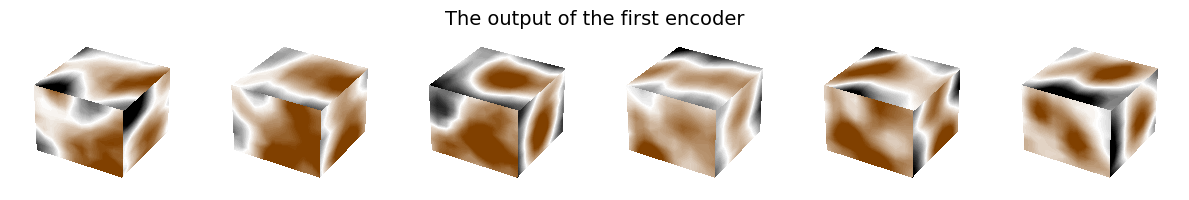

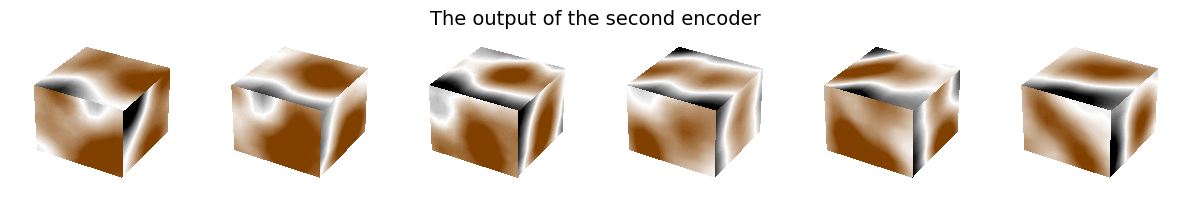

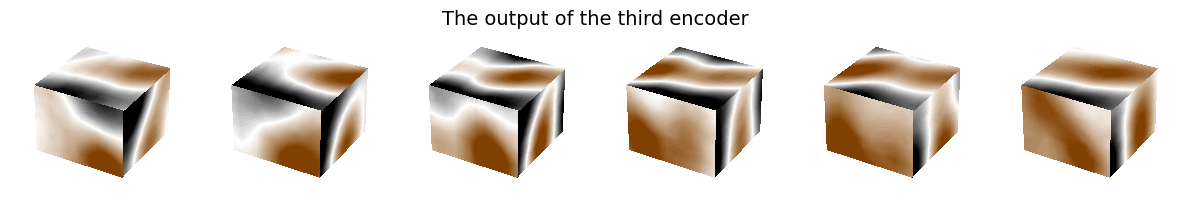

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2))
for ii in range(6):
    ax = plt.subplot(1, 6, ii + 1, projection='3d')
    plot3d(out1[600 + ii, :].reshape(12, 12, 12, order='F'), ifnewfig=False, showf=False, close=False)
    ax.set_axis_off() 
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("The output of the first encoder",size=14)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 2))
for ii in range(6):
    ax = plt.subplot(1, 6, ii + 1, projection='3d')
    plot3d(out2[600 + ii, :].reshape(12, 12, 12, order='F'), ifnewfig=False, showf=False, close=False)
    ax.set_axis_off() 
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("The output of the second encoder",size=14)
plt.tight_layout()
plt.show()

# Denoised patches
plt.figure(figsize=(12, 2))
for ii in range(6):
    ax = plt.subplot(1, 6, ii + 1, projection='3d')
    plot3d(out3[600 + ii, :].reshape(12, 12, 12, order='F'), ifnewfig=False, showf=False, close=False)
    ax.set_axis_off() 
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("The output of the third encoder",size=14)
plt.tight_layout()
plt.show()
